<a href="https://colab.research.google.com/github/lorek/MethodsClassDimRed/blob/main/MoCaDR_List_nr_14_MCMC_Metropolis_Knapsack_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Suggestion: copy the notebook to your drive first**

# Knapsack problem

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy as cp

## Knapsack problem description:

We are given $d$ items with weights $\mathbf{w}=(w_1,\ldots,w_d)$ and values $\mathbf{v}=(v_1,\ldots,v_d)$ (we assume $v_i>0, w_i>0, i=1,\ldots,d$). The maximal capacity of a knapsack is $W$.

Let $\mathbf{x}=(x_1,\ldots,x_d), x_i\in\{0,1\}$ be a vectore denoting which items we decide to take ($x_i=1$) and which not to take ($x_i=0$).

We may take items $\mathbf{x}$ if $\mathbf{w\cdot x}=\sum_{i=1}^d w_i x_i\leq W$, then the values of these items is $ \mathbf{w\cdot v}=\sum_{i=1}^d v_i x_i$

The **GOAL** is to find items $\mathbf{x}$ which we can carry and which have large(st) value, i.e.,
$$ \textrm{find}\ \textrm{argmax}_{\mathbf{x}}(\mathbf{v\cdot x}) = \textrm{argmax}_{\mathbf{x}} \sum_{i=1}^d v_i x_i $$
$$ \textrm{subject to}\ \mathbf{w\cdot x}=\sum_{i=1}^d w_i x_i\leq W$$


IDEA: Sample from distribution having large mass for "good" $\mathbf{x}$. Note that for any $\beta>0$:

$$ \ \textrm{argmax}_{\mathbf{x}} f(\mathbf{v\cdot x}) = \textrm{argmax}_{\mathbf{x}} {\exp\left(\beta \left( \mathbf{v\cdot x}\right)\right)\over z} = \textrm{argmax}_{\mathbf{x}} {\exp\left(\beta \left( \sum_{i=1}^d v_i x_i\right)\right)\over z}. $$
Thus, define the distribution:
$$\pi(\mathbf{x})=
\left\{
\begin{array}{llll}
 {\exp\left(\beta \left( \sum_{i=1}^d v_i x_i\right)\right)\over z} & \textrm{if } \mathbf{w\cdot x}\leq W,\\
 0 & \textrm{otherwise}
\end{array}
\right.$$
$z$ is a normalization constant, so that $\pi(\mathbf{x})$ is a distribution, i.e. (infeasible to compute in most cases),
$$z=\sum_{\mathbf{x}\in\{0,1\}^d: \mathbf{w\cdot x}\leq W}  \exp\left(\beta \left( \sum_{i=1}^d v_i x_i\right)\right)$$




**MAIN IDEA: SAMPLE FROM $\pi$ !**

First, check random solutions.

In [3]:
np.random.seed(1)

Specific example: Fix parameters $d$ and $W$ and set  $$w_i=5\cdot \textrm{randint}(\{1,2,\ldots,24\}), \quad v_i=i^{1.2}$$

In [4]:
d=100
W=1850 # try later e.g. W=50 (!)
#W=50

In [5]:
w=5*np.random.randint(1,24,d)
v=np.arange(d)**1.2

In [6]:
print("Mean weight = ", np.mean(w), "mean value = ",np.mean(v))

Mean weight =  57.15 mean value =  112.92267676464228


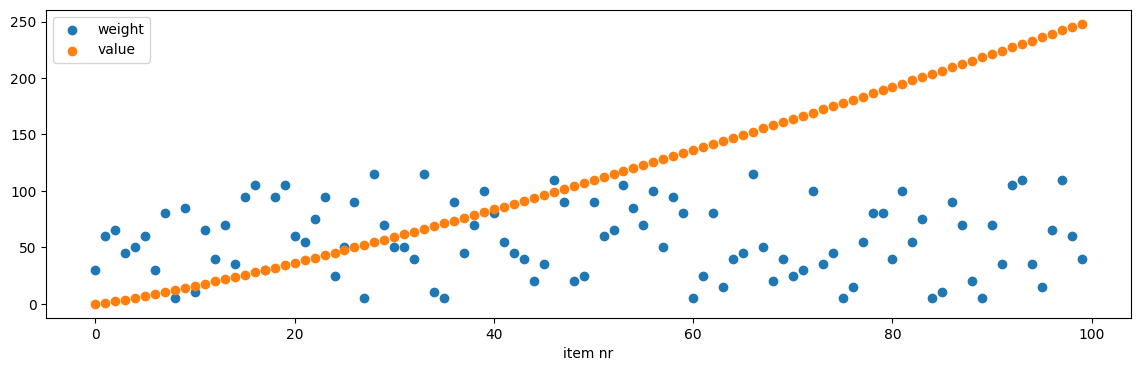

In [7]:
plt.figure(figsize=(14,4))
plt.scatter(np.arange(d),w, label="weight")
plt.scatter(np.arange(d),v, label="value")
plt.xlabel('item nr')
plt.legend()

In [8]:
np.random.seed(1)

# Random solutions

Simulating $R $ random vectors from $\{0,1\}^d$ and checking if it yielded a feasible solution. If it yields a feasible solution, store its weight $\mathbf{w\cdot x}$ and value $\mathbf{v\cdot x}$.


In [9]:
x_rand =np.random.randint(0,2,d)
print(np.sum(x_rand*w),W)

3075 1850


In [10]:
R=5000


In [11]:

nr_of_feasible_solutions=0
res_rand_w=np.array([])
res_rand_v=np.array([])

for i in np.arange(R):
  x_rand =np.random.randint(0,2,d)
  if np.sum(x_rand*w)<=W:
    res_rand_w=np.append(res_rand_w,np.sum(x_rand*w))
    res_rand_v=np.append(res_rand_v,np.sum(x_rand*v))

    nr_of_feasible_solutions=nr_of_feasible_solutions+1


In [12]:
print("nr of succesful sims: ", nr_of_feasible_solutions, " out of ",R, ", i.e., a fraction ",nr_of_feasible_solutions,"/",R,"=",np.round(nr_of_feasible_solutions/R,3))

nr of succesful sims:  4  out of  5000 , i.e., a fraction  4 / 5000 = 0.001


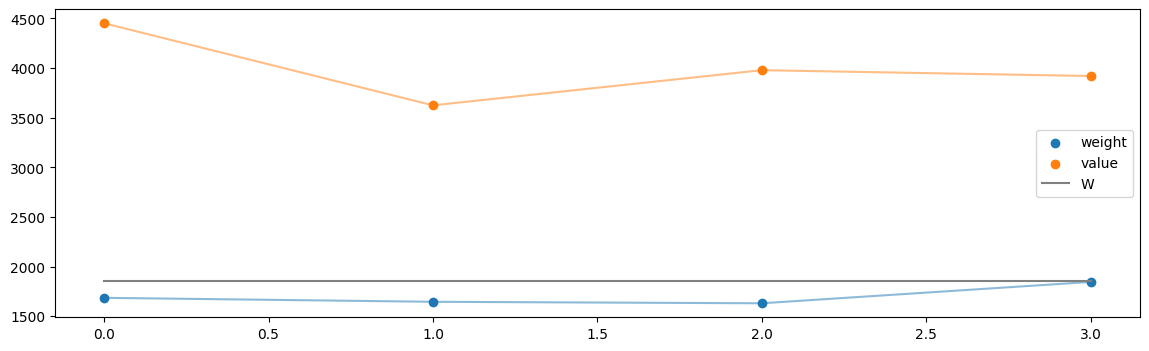

In [13]:
plt.figure(figsize=(14,4))
plt.plot(np.arange(nr_of_feasible_solutions),res_rand_w, alpha=0.5 )
plt.scatter(np.arange(nr_of_feasible_solutions),res_rand_w, label="weight")

plt.plot(np.arange(nr_of_feasible_solutions),res_rand_v, alpha=0.5 )
plt.scatter(np.arange(nr_of_feasible_solutions),res_rand_v, label="value")
plt.plot(np.arange(nr_of_feasible_solutions),W*np.ones(nr_of_feasible_solutions), c='gray', label="W")
plt.legend()


In [14]:
print("Best random solution yielded highest value = ", np.max(res_rand_v))


Best random solution yielded highest value =  4451.251900150844


# Metropolis / Gibbs


Main idea: Fix $\beta>0$ and sample from distribution $\pi$ on $E=\{0,1\}^d$:
  $$\pi(\mathbf{x})=\left\{\begin{matrix}
{1\over z} \exp\left(\beta \sum_{i=1}^d x_i v_i\right) & \textrm{ if } \sum_{i=1}^d x_i w_i\leq W,\\
  0 & \textrm{otherwise}
\end{matrix}\right.$$


## Metropolis:

In [15]:

beta=0.01 # play with beta

R=5000

res_w=np.array([])
res_v=np.array([])

#initially x=(0,0,....,0)
x=np.zeros(d)

for j in np.arange(R): # perform R steps
  i=np.random.randint(d)  # random coordinate
  x_candidate = cp.copy(x)
  x_candidate[i]=1-x[i]      # change coordinate i to opposite

  if np.sum(x_candidate*w)<W:  # if feasible
    U = np.random.uniform(0,1)
    alpha=np.minimum(1, np.exp(-2*beta*x[i]))
    if U<alpha:   # then accept with probability alpha
      x=x_candidate

  res_w=np.append(res_w,np.sum(x*w))
  res_v=np.append(res_v,np.sum(x*v))

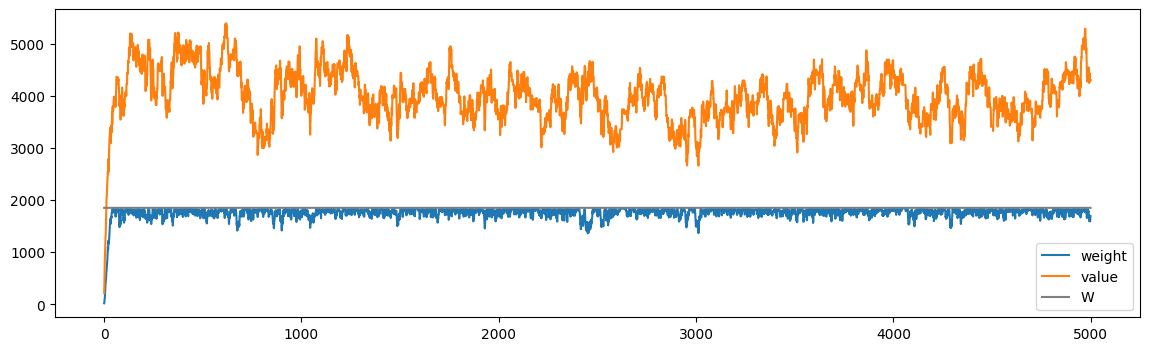

In [16]:
plt.figure(figsize=(14,4))
plt.plot(np.arange(R),res_w, label="weight")
plt.plot(np.arange(R),res_v, label="value")
plt.plot(np.arange(R),W*np.ones(R), c='gray', label="W")
plt.legend()

In [17]:
#best_random = np.round(np.max(res_rand_v),6)
best_metropolis = np.round(np.max(res_v),6)
#print("Best random solution yielded highest value = \t\t",best_random )
print("Best METROPOLIS solution yielded highest value = \t",best_metropolis )
#print("Ratio best_metropolis/best_random = \t\t\t", np.round(best_metropolis/best_random,6))

Best METROPOLIS solution yielded highest value = 	 5388.517793


In [18]:
W

1850

# Q14.1

* Provide **Gibbs sampler** for Knapsack problem.


# Traveling Salesman Problem (TSP)


We are given 13 cities in US:

![13 cities in US](https://raw.githubusercontent.com/lorek/datasets/master/tsp_13cities.png)

The distances between each of them (they are numbered somehow) are given in a matrix M (miles?)


In [29]:
M1=np.array([
        [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
    ])


In [30]:
M=M1
n=M.shape[0]

Set some permutation -- the orderding a salesman visits the cities:

$$f(\sigma)=\sum_{k=1}^{n-1}M(\sigma_k, \sigma_{k+1})+M(\sigma_n,\sigma_1).$$
  We aim at seeking
  $$\sigma^*=\textrm{argmin}_{\sigma} f(\sigma) = \textrm{argmax}_{\sigma} \exp(-f(\sigma\cdot \beta))=\textrm{argmax}_{\sigma} {\exp(-f(\sigma\cdot \beta))\over C},$$
  here $\beta>0$ (a parameter), $C$ is a normalization constant, so that
  $$\pi(\sigma)={\exp(-f(\sigma\cdot \beta))\over C}$$
   is a distribution on permutations.

   Recall: main idea: sample from $\pi$.

In [31]:
def calc_dist(M,sigma):
# a function computing total distance of a salesman
# with given M and sigma
# aka f(sigma)
	n=np.shape(sigma)[0];
	fsum=0;
	for i in np.arange(0,n-1):
		fsum = fsum + M[sigma[i],sigma[i+1]]
	fsum = fsum + M[sigma[n-1],sigma[0]]
	return fsum

Check some random solutions:

BEST RANDOM solution yielded:  10408.0


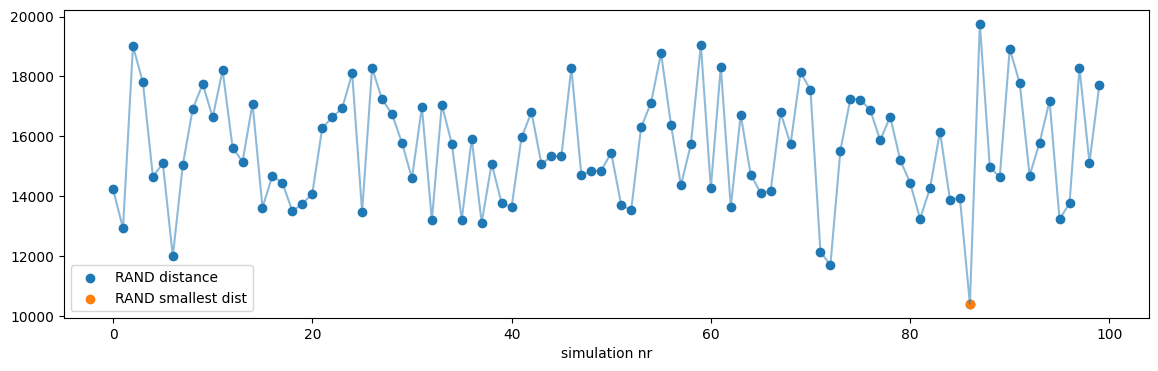

In [39]:
#Try several random permutations:
np.random.seed(1)

R=100

res_rand_dist=np.array([])

for i in np.arange(R):
  sigma=np.random.permutation(n);   # random permutation
  dist = calc_dist(M,sigma)         # distance
  res_rand_dist=np.append(res_rand_dist,dist)

plt.figure(figsize=(14,4))
plt.plot(np.arange(R),res_rand_dist, alpha=0.5 )
plt.scatter(np.arange(R),res_rand_dist, label="RAND distance")
plt.scatter(np.argmin(res_rand_dist),res_rand_dist[np.argmin(res_rand_dist)], label="RAND smallest dist")
plt.xlabel('simulation nr')
plt.legend()

print("BEST RANDOM solution yielded: ", res_rand_dist[np.argmin(res_rand_dist)])

## Metropolis algorithm for TSP

 (See **Q14.2** below)

In [54]:
def tsp_calc_likelihood_ratio(M, sigma, i, j):
  ratio=1
  # TO DO _______
  # TO DO _______
  # TO DO _______

  return ratio;

In [55]:
sigma=np.random.permutation(n); #initial random permutation
np.random.seed(3)

R = 1000
beta = 0.004 #play with beta


res_metropolis_dist=np.array([])

for k in np.arange(R):

    sigma_candidate = cp.copy(sigma)
    i,j=np.random.randint(n,size=2)           # choose i,j uniformly from {1,2,..,n}

    sigma_candidate[[i,j]]=sigma_candidate[[j,i]]

    #pi_sigma =          np.exp(-beta*calc_dist(M,sigma))                # pi(sigma) NOT NORMALIZED
    #pi_sigma_candidate= np.exp(-beta*calc_dist(M,sigma_candidate))      # pi(sigma_candidate) NOT NORMALIZED
    ratio = tsp_calc_likelihood_ratio(M,sigma,i,j) #pi_sigma_candidate/pi_sigma                      #this can be computed more efficiently! (cancel out...)

    alpha = np.min([1,ratio])

    U=np.random.uniform(0,1)

    if (U<=alpha):                      # accept candidate with prob alpha
      sigma=cp.copy(sigma_candidate)

    res_metropolis_dist=np.append(res_metropolis_dist,calc_dist(M,sigma))

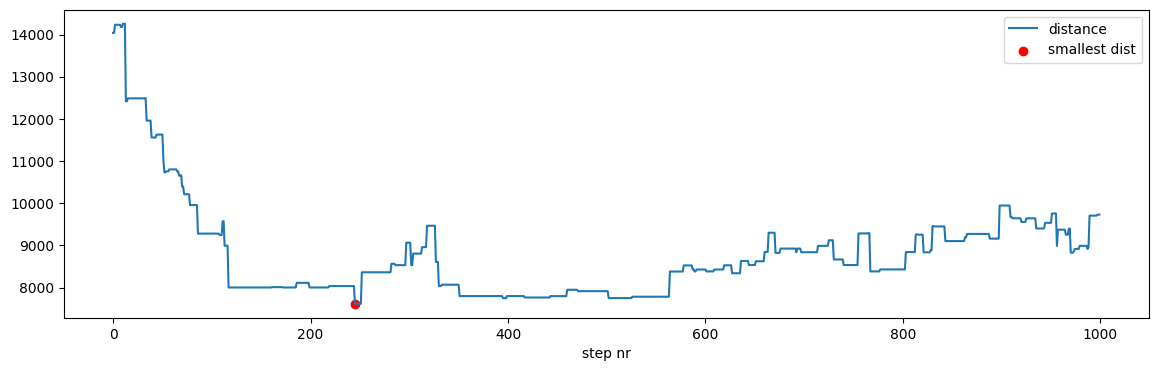

In [56]:
plt.figure(figsize=(14,4))
plt.plot(np.arange(R),res_metropolis_dist,  label="distance" )
plt.scatter(np.argmin(res_metropolis_dist),res_metropolis_dist[np.argmin(res_metropolis_dist)], label="smallest dist", color='red')
plt.xlabel('step nr')
plt.legend()

In [57]:
print("Best (smallest) random distance = \t\t", np.min(res_rand_dist) , " for simulation nr ",np.argmin(res_rand_dist))
print("Best (smallest) Metropolis distance = \t\t", np.min(res_metropolis_dist) , " for step ",np.argmin(res_metropolis_dist))

print("\nRatio [smallest Metropolis]/[smallest random] = ",np.round(np.min(res_metropolis_dist)/np.min(res_rand_dist),6))

Best (smallest) random distance = 		 10408.0  for simulation nr  86
Best (smallest) Metropolis distance = 		 7619.0  for step  245

Ratio [smallest Metropolis]/[smallest random] =  0.732033


# Q14.2
* Finish function `tsp_calc_likelihood_ratio` so that above works as expected (Metropolis for TSP)
* Try several differnt parameters `beta`

* Reimplement above Metropolis algorithm for TSP using the following candidates:
Assume that current permutation is $\sigma$, then choose uniformly at random $i<j$, assume that
 $$\sigma=(\sigma(1),\ldots,\sigma({i-1}),\underbrace{\sigma(i),\ldots,\sigma(j-1)\sigma(j)}_{\textrm{to be reversed}},\sigma({j+1})\ldots,\sigma(n)).$$
 Now, a candidate is  
  $$\sigma'=(\sigma(1),\ldots,\sigma({i-1}),\underbrace{\sigma(j),\sigma(j-1),\ldots, \sigma(i)}_{\textrm{reversed}},\sigma({j+1})\ldots,\sigma(n)).$$